In [ ]:
# download data: https://drive.google.com/file/d/1U6WD6V563igKFUedzVT_hCvFeY2-tFE_/view?usp=sharing

# From Scratch

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

In [22]:
#PATH = '/content/gdrive/My Drive/data/cats_and_dogs_small/'
PATH = 'cats_and_dogs_small/'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 128
IMG_SIZE = (160, 160)
BUFFER_SIZE = BATCH_SIZE*5

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [23]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


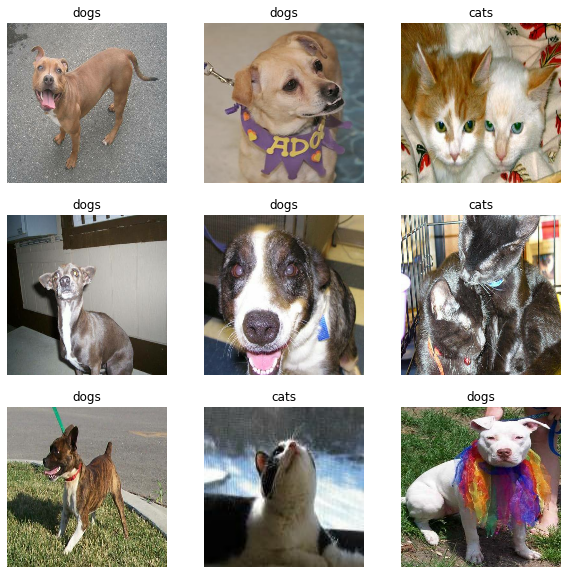

In [24]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [25]:
train_dataset = train_dataset.prefetch(buffer_size=BUFFER_SIZE)
validation_dataset = validation_dataset.prefetch(buffer_size=BUFFER_SIZE)

In [26]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

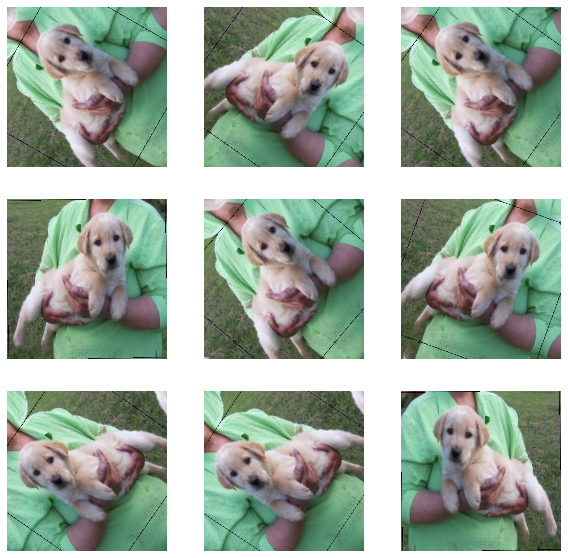

In [27]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [28]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [29]:
print(IMG_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

(160, 160)
(160, 160, 3)


In [30]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [31]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 5, 5, 512)


In [32]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 512)


In [33]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 1)


In [34]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [35]:
base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_strided_slice_1  [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_1 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)              

In [37]:
len(model.trainable_variables)

28

In [38]:
history_fine = model.fit(train_dataset,
                         epochs=250,
                         validation_data=validation_dataset)

Epoch 1/250
16/16 [==============================] - 7s 458ms/step - loss: 0.6992 - accuracy: 0.4985 - val_loss: 0.6878 - val_accuracy: 0.5020
Epoch 2/250
16/16 [==============================] - 7s 454ms/step - loss: 0.6924 - accuracy: 0.4980 - val_loss: 0.6757 - val_accuracy: 0.5000
Epoch 3/250
16/16 [==============================] - 7s 459ms/step - loss: 0.6830 - accuracy: 0.5110 - val_loss: 0.6618 - val_accuracy: 0.5230
Epoch 4/250
16/16 [==============================] - 7s 459ms/step - loss: 0.6765 - accuracy: 0.5275 - val_loss: 0.6604 - val_accuracy: 0.6210
Epoch 5/250
16/16 [==============================] - 7s 459ms/step - loss: 0.6726 - accuracy: 0.5455 - val_loss: 0.6434 - val_accuracy: 0.5720
Epoch 6/250
16/16 [==============================] - 7s 463ms/step - loss: 0.6654 - accuracy: 0.5580 - val_loss: 0.6404 - val_accuracy: 0.6140
Epoch 7/250
16/16 [==============================] - 7s 461ms/step - loss: 0.6639 - accuracy: 0.5710 - val_loss: 0.6783 - val_accuracy: 0.6450

Epoch 113/250
16/16 [==============================] - 8s 476ms/step - loss: 0.4914 - accuracy: 0.7450 - val_loss: 0.5150 - val_accuracy: 0.7310
Epoch 114/250
16/16 [==============================] - 8s 490ms/step - loss: 0.4682 - accuracy: 0.7675 - val_loss: 0.5777 - val_accuracy: 0.6650
Epoch 115/250
16/16 [==============================] - 8s 491ms/step - loss: 0.4939 - accuracy: 0.7435 - val_loss: 0.5714 - val_accuracy: 0.6700
Epoch 116/250
16/16 [==============================] - 8s 485ms/step - loss: 0.4835 - accuracy: 0.7525 - val_loss: 0.5111 - val_accuracy: 0.7270
Epoch 117/250
16/16 [==============================] - 8s 474ms/step - loss: 0.4716 - accuracy: 0.7605 - val_loss: 0.5072 - val_accuracy: 0.7550
Epoch 118/250
16/16 [==============================] - 8s 476ms/step - loss: 0.4937 - accuracy: 0.7515 - val_loss: 0.5129 - val_accuracy: 0.7670
Epoch 119/250
16/16 [==============================] - 8s 481ms/step - loss: 0.4750 - accuracy: 0.7705 - val_loss: 0.6128 - val_ac

16/16 [==============================] - 7s 469ms/step - loss: 0.3491 - accuracy: 0.8350 - val_loss: 0.6268 - val_accuracy: 0.7070
Epoch 226/250
16/16 [==============================] - 8s 473ms/step - loss: 0.3895 - accuracy: 0.8150 - val_loss: 0.4947 - val_accuracy: 0.7860
Epoch 227/250
16/16 [==============================] - 8s 481ms/step - loss: 0.3605 - accuracy: 0.8305 - val_loss: 0.4899 - val_accuracy: 0.7800
Epoch 228/250
16/16 [==============================] - 8s 487ms/step - loss: 0.3705 - accuracy: 0.8225 - val_loss: 0.5452 - val_accuracy: 0.7430
Epoch 229/250
16/16 [==============================] - 8s 480ms/step - loss: 0.3724 - accuracy: 0.8170 - val_loss: 0.4804 - val_accuracy: 0.7700
Epoch 230/250
16/16 [==============================] - 8s 473ms/step - loss: 0.3514 - accuracy: 0.8320 - val_loss: 0.5131 - val_accuracy: 0.7720
Epoch 231/250
16/16 [==============================] - 8s 474ms/step - loss: 0.3696 - accuracy: 0.8330 - val_loss: 0.5194 - val_accuracy: 0.7590

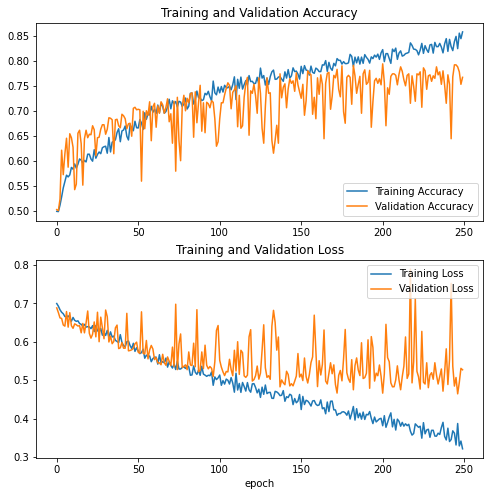

In [40]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
